<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "15g") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *

In [3]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [4]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [5]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [6]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [7]:
df = df.sample(False, 0.5)

In [8]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [9]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [10]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load('/workspace/data/criteo_models/mllib_practice_model')

In [11]:
pipeline_model.stages

[StringIndexer_12515b06d7ac,
 StringIndexer_654f0b0cb784,
 OneHotEncoderEstimator_0f5d78ae05b8,
 VectorAssembler_9f7a6ab4f792]

In [12]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1395, 550)

Итоговая размерность пространства фичей

In [13]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels) + 2
dim

1960

In [14]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1832777

In [15]:
df.show(10)

+-----+--------------------+---+
|label|            features| id|
+-----+--------------------+---+
|    1|(1960,[1,2,3,4,5,...| 26|
|    1|(1960,[0,1,3,4,5,...| 41|
|    0|(1960,[1,3,4,5,6,...| 85|
|    0|(1960,[1,2,3,4,5,...|235|
|    0|(1960,[1,2,3,4,5,...|252|
|    1|(1960,[2,7,13,140...|302|
|    0|(1960,[1,7,8,14,1...|313|
|    1|(1960,[1,2,3,7,8,...|329|
|    0|(1960,[1,3,7,8,12...|348|
|    0|(1960,[3,4,5,6,7,...|376|
+-----+--------------------+---+
only showing top 10 rows



In [16]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [17]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [18]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [19]:
model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb.model'))

### Evaluation

In [20]:
import pyspark.sql.functions as F

def calibration(model, df):
    df_stats = df.select(
        F.mean(F.col('label')).alias('mean'),
    ).collect()
    empirical_avg_ctr = df_stats[0]['mean']

    df = model.transform(df)
    df_stats = df.select(
        F.mean(F.col('prediction')).alias('mean'),
    ).collect()
    predicted_avg_ctr = df_stats[0]['mean']
    
    return predicted_avg_ctr / empirical_avg_ctr

In [21]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [22]:
import pandas as pd

def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """

    metrics = []
    data = {'metrics': []}
    
    control_metrics = {}
    for metric_name, metric_val in groups[control_name]:
        control_metrics[metric_name] = metric_val
        metrics.append(metric_name)
        data['metrics'].append(metric_name)
    
    for model, metric_pairs in groups.items():
        data[model] = [0 for i in range(len(metrics))]
        for metric_name, metric_val in metric_pairs:
            idx = metrics.index(metric_name)
            xt = metric_val
            xc = control_metrics[metric_name]
            data[model][idx] = (xt - xc) / xc * 100
    
    return pd.DataFrame.from_dict(data).set_index('metrics')

In [23]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7276326897529202

In [24]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.729490545998874

In [25]:
all_metrics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [26]:
from pyspark.ml.classification import LogisticRegressionModel

lr_model_path = '/workspace/data/criteo_models/lr_model'
lr_model = LogisticRegressionModel.load(lr_model_path)

In [31]:
import numpy as np
from metrics import rocauc, logloss, ne

groups = {}

def add_group(groups, df, model, model_name, prob_col='probability'):
    metric_calcer = lambda metric: metric(model, df, prob_col)
    metrics = {
        'rocauc': metric_calcer(rocauc),
        'logloss': metric_calcer(logloss),
        'ne': metric_calcer(ne),
        'calibration': calibration(model, df)
    }

    groups[model_name] = []
    
    for metric_name, metric_val in metrics.items():
        groups[model_name].append((metric_name, metric_val))

In [32]:
add_group(groups, test_df, lr_model, 'LR')

Построить таблицу ATE используя метод `get_ate`

In [33]:
add_group(groups, test_df, model, 'xgb', 'probabilities')

In [34]:
get_ate(groups, 'LR')

,LR,xgb
metrics,,
rocauc,0.0,4.243265
calibration,0.0,460.687161
logloss,0.0,-5.662727
ne,0.0,-5.662727


## New Model
### Prepare Data

In [35]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(False, 0.5)

In [36]:
df = df.fillna(0, subset=num_columns)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [37]:
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.param.shared import *


class _MeanTargetEncoderModelParams(Params):
    
    categories = Param(Params._dummy(), "categories",
                       "list of feature categories",
                       typeConverter=TypeConverters.toListString)
    
    cat_mean_targets = Param(Params._dummy(), "cat_mean_targets",
                             "list of mean targets for categories",
                             typeConverter=TypeConverters.toListFloat)
    
    cat_cnt = Param(Params._dummy(), "cat_cnt",
                    "number of samples in the category",
                    typeConverter=TypeConverters.toListInt)
    
    smoothing_k = Param(Params._dummy(), "smoothing_k",
                        "for smoothing",
                        typeConverter=TypeConverters.toInt)
    
    total_mean = Param(Params._dummy(),  "total_mean",
                       "total mean of the fitted dataset",
                       typeConverter=TypeConverters.toFloat)

    input_col = Param(Params._dummy(), "input_col",
                      "input column name",
                      typeConverter=TypeConverters.toString)

    output_col = Param(Params._dummy(),  "output_col",
                       "output column name",
                       typeConverter=TypeConverters.toString)
    
    


# Fitted Model
class MeanTargetEncoderModel(pyspark.ml.Model, 
                             pyspark.ml.util.DefaultParamsReadable, 
                             pyspark.ml.util.DefaultParamsWritable,
                             _MeanTargetEncoderModelParams):
    
    @keyword_only
    def __init__(self, input_col=None, output_col=None, categories=[], 
                 cat_mean_targets=[], cat_cnt=[], total_mean=0,
                 smoothing_k=20):
        super(MeanTargetEncoderModel, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, input_col=None, output_col=None, categories=[], 
                 cat_mean_targets=[], cat_cnt=[], total_mean=0,
                 smoothing_k=20):
        kwargs = self._input_kwargs
        self._set(**kwargs)
        return self

    def _transform(self, df):
        total_mean = self.getOrDefault(self.total_mean)
        categories = self.getOrDefault(self.categories)
        cat_mean_targets = self.getOrDefault(self.cat_mean_targets)
        cat_cnt = self.getOrDefault(self.cat_cnt)
        input_col = self.getOrDefault(self.input_col)
        output_col = self.getOrDefault(self.output_col)
        k = self.getOrDefault(self.smoothing_k)
        
        mean_targets = dict(zip(categories, cat_mean_targets))
        counts = dict(zip(categories, cat_cnt))
        
        def encoder(cat):
            n = 0
            mean_target = 0
            if cat in mean_targets:
                n = counts[cat]
                mean_target = mean_targets[cat]
            return (n * mean_target + k * total_mean) / (n + k)

        encoder_udf = udf(encoder, FloatType())
        
        return df.withColumn(output_col, encoder_udf(F.col(input_col)))


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):

    def __init__(self, inputCol, targetCol, featuresCol):
        super(MeanTargetEncoder, self).__init__()
        self.inputCol = inputCol
        self.targetCol = targetCol
        self.featuresCol = featuresCol
    
    def _fit(self, df):
        cat_stats = {}
        total_cnt = 0
        total_sum = 0
        total_mean = 0

        stats_dict = df\
            .select([self.inputCol, self.targetCol]) \
            .groupby(self.inputCol) \
            .agg(F.mean(self.targetCol).alias('cat_mean'), \
                 F.count(self.targetCol).alias('cat_cnt')) \
            .toPandas().to_dict()

        for i in stats_dict[self.inputCol]:
            cat = stats_dict[self.inputCol][i]
            cnt = stats_dict['cat_cnt'][i]
            mean = stats_dict['cat_mean'][i]

            total_cnt += cnt
            total_sum += cnt * mean
            cat_stats[cat] = (mean, cnt)

        categories = list(cat_stats.keys())
        cat_mean_targets = list(map(lambda x: x[0], list(cat_stats.values())))
        cat_cnt = list(map(lambda x: x[1], list(cat_stats.values())))
        
        assert(total_cnt == df.count())
            
        total_mean = total_sum / total_cnt
        
        return MeanTargetEncoderModel(input_col=self.inputCol, output_col=self.featuresCol,
                                      categories=categories, 
                                      cat_mean_targets=cat_mean_targets,
                                      cat_cnt=cat_cnt,
                                      total_mean=total_mean,
                                      smoothing_k=20)

#### Pipeline

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [39]:
!rm -r /workspace/data/criteo/pipeline_model_2/

In [40]:
pipeline_model = pipeline.fit(df)
pipeline_model.save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [41]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [42]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1832199

In [43]:
train_df_mte, val_df_mte, test_df_mte = split_by_col(df, 'id', [0.8, 0.1, 0.1])

In [44]:
dim = len(num_columns) + len(cat_columns)
dim

15

### Train

Train XGBoost on the new set of features

In [45]:
xgb_mte_model = estimator.fit(train_df_mte)

In [46]:
xgb_mte_model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb_mte.model'))

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [47]:
add_group(groups, test_df_mte, xgb_mte_model, 'xgb_mte', 'probabilities')

In [48]:
get_ate(groups, 'LR')

,LR,xgb,xgb_mte
metrics,,,
rocauc,0.0,4.243265,5.363811
calibration,0.0,460.687161,541.411838
logloss,0.0,-5.662727,-6.475749
ne,0.0,-5.662727,-6.533986


In [49]:
get_ate(groups, 'xgb')

,LR,xgb,xgb_mte
metrics,,,
rocauc,-4.070541,0.0,1.074933
calibration,-82.164742,0.0,14.397454
logloss,6.002641,0.0,-0.861824
ne,6.002641,0.0,-0.923557


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [50]:
!pip3.5 install shap

In [51]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb_mte.model'))

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


[20:31:55] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [52]:
print(bst.get_dump()[0])

0:[f0<0.999998987] yes=1,no=2,missing=1
	1:[f10<1.99999905] yes=3,no=4,missing=3
		3:[f14<0.276651919] yes=7,no=8,missing=8
			7:[f6<0.999998987] yes=15,no=16,missing=15
				15:[f14<0.169043735] yes=31,no=32,missing=32
					31:[f4<261957] yes=63,no=64,missing=64
						63:[f7<3.99999905] yes=127,no=128,missing=127
							127:[f14<0.123677664] yes=253,no=254,missing=254
								253:leaf=-0.253601491
								254:leaf=-0.232638434
							128:[f14<0.14989081] yes=255,no=256,missing=256
								255:leaf=-0.264806867
								256:leaf=-0.250414789
						64:leaf=-0.272373319
					32:[f2<5.99999905] yes=65,no=66,missing=65
						65:[f4<128897] yes=129,no=130,missing=130
							129:[f7<1.99999905] yes=257,no=258,missing=257
								257:leaf=-0.188089952
								258:leaf=-0.218355089
							130:[f12<40] yes=259,no=260,missing=260
								259:leaf=-0.248038113
								260:leaf=-0.230983824
						66:[f2<38] yes=131,no=132,missing=132
							131:[f4<74085] yes=261,no=262,missing=262
								261:leaf=

In [53]:
sample_df = df.sample(False, 0.05)
sample_df.count()

91889

In [54]:
from scipy.sparse import csr_matrix


def df_to_csr(df):
    data = []
    row_ind = []
    col_ind = []
    
    vecs = df.rdd.map(lambda row: row.features).collect()
    dim = vecs[0].size

    for i, vec in enumerate(vecs):
        if isinstance(vec, pyspark.ml.linalg.SparseVector):
            for idx, val in zip(vec.indices, vec.values):
                data.append(val)
                row_ind.append(i)
                col_ind.append(idx)
        else:
            indices = list(range(len(vec.values)))
            for idx, val in zip(indices, vec.values):
                data.append(val)
                row_ind.append(i)
                col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(vecs), dim))

In [55]:
dim

15

In [60]:
%%time
X = df_to_csr(sample_df)
dtest = xgb.DMatrix(X)

CPU times: user 4.56 s, sys: 162 ms, total: 4.72 s
Wall time: 6.77 s


In [61]:
X_arr = X.toarray()

In [62]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

CPU times: user 3min 47s, sys: 146 ms, total: 3min 47s
Wall time: 26.3 s


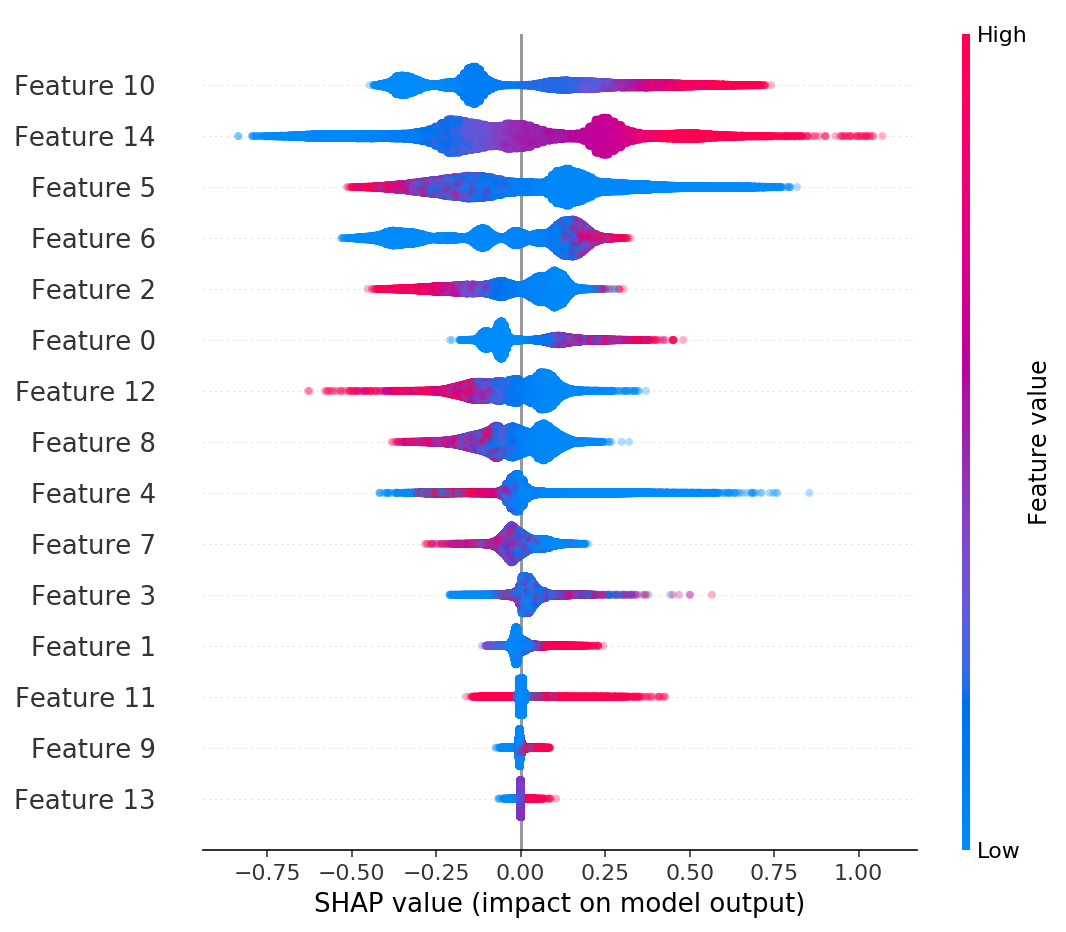

In [63]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [64]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [65]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

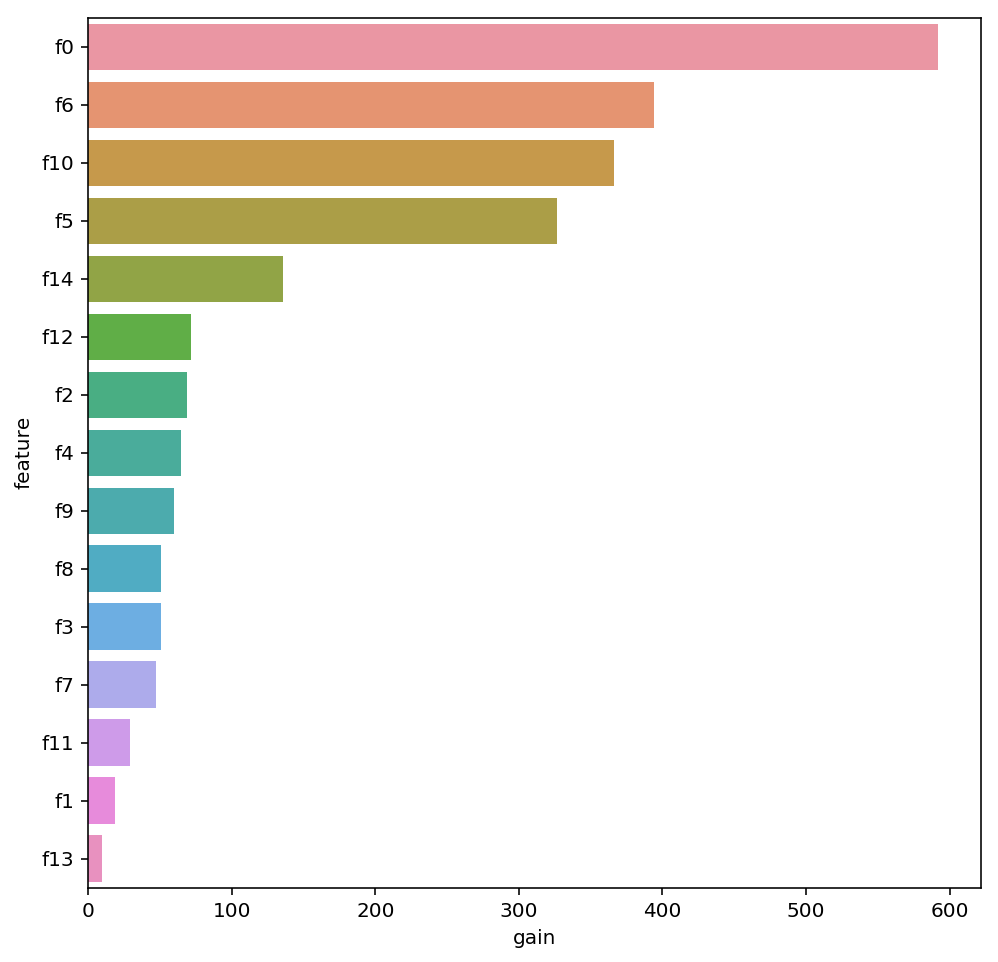

In [66]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [97]:
# ТУДУ Тут легко добавить функциональность load/save (мы умеем сериализовать xgb модели), но мне сейчас лень, это для задания вроде не нужно

import xgboost as xgb
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.window import Window as W

# Fitted Model
class XgbLeafEncoderModel(pyspark.ml.Model):
    
    @keyword_only
    def __init__(self, outputCol="xgb_leaf_features", maxDepth=4, xgbSavePath="/workspace/data/criteo_models/facebook_xgb"):
        super(XgbLeafEncoderModel, self).__init__()
#         kwargs = self._input_kwargs
#         self.setParams(**kwargs)
        self.outputCol = outputCol
        self.xgbSavePath = xgbSavePath
        self.xgbBooster = xgb.Booster()
        self.xgbBooster.load_model(self.xgbSavePath)
        self.maxDepth = maxDepth
        self.treeLimit = 10

    @keyword_only
    def setParams(self, outputCol="xgb_leaf_features", maxDepth=4, xgbSavePath="/workspace/data/criteo_models/facebook_xgb"):
        kwargs = self._input_kwargs
#         self._set(**kwargs)
#         return self
        self.outputCol = outputCol
        self.xgbSavePath = xgbSavePath
        self.xgbBooster = xgb.Booster()
        self.xgbBooster.load_model(self.xgbSavePath)
        self.maxDepth = maxDepth
        self.treeLimit = 10

    def _transform(self, df):
#   this one fails with some strange error from xgboost
#
#         def encoder(features):
#             def one_hot_leaf(leaf_id):
#                 n_leaves = 2 ** (self.maxDepth + 1)
#                 res = np.zeros(n_leaves)
#                 res[leaf_id] = 1
#                 return res
#             sparse = self.xgbBooster.predict(xgb.DMatrix(np.array([features])), ntree_limit=10, pred_leaf=True)
#             return np.concatenate([one_hot_leaf(leaf_id) for leaf_id in sparse[0]])

#         encoder_udf = udf(encoder, ArrayType(IntegerType()))

#         return df.withColumn(self.outputCol, encoder_udf(F.col('features')))

        def list_to_sv(l):
            res = {}
            idx = 0
            for i in l:
                res[idx + i] = 1
                idx += 2 ** (self.maxDepth + 1)
            return SparseVector(idx, res)

        print("df -> csr")
        
        X = df_to_csr(df)
        leaves = self.xgbBooster.predict(xgb.DMatrix(X), pred_leaf=True, ntree_limit=self.treeLimit)
        leaves = leaves.tolist()
        
        print("preds -> sv list")
        
        leaves_sv = list(map(lambda el: (el[0] + 1, list_to_sv(el[1])), enumerate(leaves)))
        print(leaves_sv[0])

        print("sv list -> df")

        leaves_df = sc.parallelize(leaves_sv).toDF(['row_id', self.outputCol])
        leaves_df.show(5)
        
        print("row ids")
        
        df = df.withColumn("tmp_idx", F.monotonically_increasing_id())
        windowSpec = W.orderBy("tmp_idx")
        df = df.withColumn("row_id", F.row_number().over(windowSpec)).drop('tmp_idx')
        df.show(5)
        
        print("join")
        
        return df.join(leaves_df, 'row_id').drop('row_id')


# Estimator
class XgbLeafEncoder(pyspark.ml.Estimator):

    def __init__(self, outputCol="xgd_leaf_features", maxDepth=4, xgbSavePath="/workspace/data/criteo_models/facebook_xgb"):
        super(XgbLeafEncoder, self).__init__()
        self.outputCol = outputCol
        self.xgbSavePath = xgbSavePath
        self.maxDepth = maxDepth
    
    def _fit(self, df):
        estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label",
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=self.maxDepth,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        xgbModel = estimator.fit(df)
        xgbModel._call_java("booster").saveModel(self.xgbSavePath)
        
        return XgbLeafEncoderModel(outputCol=self.outputCol,
                                   xgbSavePath=self.xgbSavePath,
                                   maxDepth=self.maxDepth)

## Train

In [128]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression


# cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

# mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
#                         for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

# assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

xgb_encoder = XgbLeafEncoder(outputCol="xgb_leaf_features")
lr_xgb_leaves = LogisticRegression(regParam=1.0, featuresCol='xgb_leaf_features')

pipeline = Pipeline(stages=[xgb_encoder, lr_xgb_leaves])
fair_model = pipeline.fit(train_df)

[22:18:18] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
df -> csr
preds -> sv list
(1, SparseVector(320, {30: 1.0, 62: 1.0, 94: 1.0, 126: 1.0, 158: 1.0, 190: 1.0, 222: 1.0, 254: 1.0, 286: 1.0, 310: 1.0}))
sv list -> df
+------+--------------------+
|row_id|   xgb_leaf_features|
+------+--------------------+
|     1|(320,[30,62,94,12...|
|     2|(320,[18,57,90,12...|
|     3|(320,[30,60,94,12...|
|     4|(320,[28,52,92,11...|
|     5|(320,[28,51,86,11...|
+------+--------------------+
only showing top 5 rows

row ids
+-----+--------------------+---+------+
|label|            features| id|row_id|
+-----+--------------------+---+------+
|    1|(1960,[1,2,3,4,5,...| 26|     1|
|    1|(1960,[0,1,3,4,5,...| 41|     2|
|    0|(1960,[1,3,4,5,6,...| 85|     3|
|    0|(1960,[1,2,3,4,5,...|235|     4|
|    0|(1960,[1,2,3,4,5,...|252|     5|
+-----+--------------------+---+------+
only showing top 5 rows

join


## Evaluation

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [129]:
add_group(groups, test_df, fair_model, 'FAIR', 'probability')

df -> csr
preds -> sv list
(1, SparseVector(320, {28: 1.0, 54: 1.0, 84: 1.0, 118: 1.0, 148: 1.0, 182: 1.0, 213: 1.0, 245: 1.0, 275: 1.0, 318: 1.0}))
sv list -> df
+------+--------------------+
|row_id|   xgb_leaf_features|
+------+--------------------+
|     1|(320,[28,54,84,11...|
|     2|(320,[28,52,86,11...|
|     3|(320,[28,52,91,11...|
|     4|(320,[28,52,85,11...|
|     5|(320,[24,59,91,12...|
+------+--------------------+
only showing top 5 rows

row ids
+-----+--------------------+------------+------+
|label|            features|          id|row_id|
+-----+--------------------+------------+------+
|    1|(1960,[1,4,7,8,13...|506806565609|     1|
|    0|(1960,[1,2,3,4,7,...|506806565612|     2|
|    0|(1960,[2,3,4,5,6,...|506806565625|     3|
|    1|(1960,[1,2,3,4,7,...|506806565626|     4|
|    0|(1960,[2,4,5,6,7,...|506806565664|     5|
+-----+--------------------+------------+------+
only showing top 5 rows

join
df -> csr
preds -> sv list
(1, SparseVector(320, {28: 1.0, 54: 

In [130]:
get_ate(groups, 'LR')

,FAIR,LR,xgb,xgb_mte
metrics,,,,
rocauc,2.117934,0.0,4.243265,5.363811
calibration,31.066908,0.0,460.687161,541.411838
logloss,-2.517532,0.0,-5.662727,-6.475749
ne,-2.517532,0.0,-5.662727,-6.533986


In [ ]:
# Т.е у меня моделька от Facebook получилась хуже, чем просто XGB и XGB + MTE
# Правда, у себя я использовал только первые 10 деревьев, что прям мало.
# Возможно потом попробую с большим кол-вом деревьев и большим кол-вом итераций LR
# (просто это сильно увеличивает время исполнения, а я уже очень хочу спать...)

### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [131]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)
df = df.fillna(0, subset=num_columns)

In [132]:
one_hot_model = PipelineModel.load('/workspace/data/criteo_models/mllib_practice_model')

In [133]:
df = one_hot_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

3664931

In [134]:
fair_model = pipeline.fit(df) # fit on full df

[22:30:42] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
df -> csr
preds -> sv list
(1, SparseVector(320, {29: 1.0, 55: 1.0, 87: 1.0, 121: 1.0, 151: 1.0, 186: 1.0, 215: 1.0, 247: 1.0, 279: 1.0, 312: 1.0}))
sv list -> df
+------+--------------------+
|row_id|   xgb_leaf_features|
+------+--------------------+
|     1|(320,[29,55,87,12...|
|     2|(320,[30,62,94,12...|
|     3|(320,[20,61,93,12...|
|     4|(320,[18,57,90,12...|
|     5|(320,[30,60,92,12...|
+------+--------------------+
only showing top 5 rows

row ids
+-----+--------------------+---+------+
|label|            features| id|row_id|
+-----+--------------------+---+------+
|    1|(1960,[1,4,6,8,10...| 12|     1|
|    1|(1960,[1,2,3,4,5,...| 26|     2|
|    0|(1960,[0,2,3,4,5,...| 39|     3|
|    1|(1960,[0,1,3,4,5,...| 41|     4|
|    0|(1960,[1,3,4,5,6,...| 85|     5|
+-----+--------------------+---+------+
only showing top 5 rows

join


In [135]:
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)
test_df = test_df.fillna(0, subset=num_columns)

In [137]:
test_df = one_hot_model \
    .transform(test_df) \
    .select('features', 'id') \
    .cache()

test_df.count()

917961

In [138]:
test_predictions = fair_model.transform(test_df)

df -> csr
preds -> sv list
(1, SparseVector(320, {23: 1.0, 57: 1.0, 90: 1.0, 121: 1.0, 153: 1.0, 185: 1.0, 218: 1.0, 250: 1.0, 274: 1.0, 314: 1.0}))
sv list -> df
+------+--------------------+
|row_id|   xgb_leaf_features|
+------+--------------------+
|     1|(320,[23,57,90,12...|
|     2|(320,[27,54,86,11...|
|     3|(320,[23,51,83,11...|
|     4|(320,[29,62,92,12...|
|     5|(320,[28,52,83,11...|
+------+--------------------+
only showing top 5 rows

row ids
+--------------------+------------+------+
|            features|          id|row_id|
+--------------------+------------+------+
|(1960,[1,2,3,4,5,...|566935904713|     1|
|(1960,[1,2,4,7,8,...|566935904715|     2|
|(1960,[1,2,3,4,5,...|566935904727|     3|
|(1960,[1,2,3,4,5,...|566935904737|     4|
|(1960,[1,2,3,4,7,...|566935904741|     5|
+--------------------+------------+------+
only showing top 5 rows

join


In [139]:
subdf = test_predictions.select(['id', 'probability']).rdd.map(lambda r: (r[0], float(r[1][1]))).toDF(['id', 'proba'])

In [140]:
subdf.repartition(1).write.csv('/workspace/data/criteo_fair_submission.csv')